In [5]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
from mpltools import style
from mpltools import layout
style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
from IPython.display import Image
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import *
from sklearn.datasets import load_digits
from sklearn import svm
from sklearn.naive_bayes import *
from sknn import mlp
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from scipy.stats import ttest_ind
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from scipy.stats import pearsonr
from minepy import MINE
from sklearn import cross_validation

In [6]:
!ls

EDA.ipynb               calendar_ref.csv        daily_aggregate.csv     roaming_monthly.csv     submission.csv          train.csv
Untitled.ipynb          contract_ref.csv        daily_aggregate.csv.zip sample_submission.csv   test.csv                twitter-spam.ipynb


In [15]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
daily = pd.read_csv("daily_aggregate.csv")
roaming = pd.read_csv("roaming_monthly.csv")
calendar = pd.read_csv("calendar_ref.csv")
contract = pd.read_csv("contract_ref.csv")

In [25]:
(train["TARGET"] == 1).sum() * 1.0 / len(train)  

0.20122775847895841

In [18]:
calendar.head()

,DATE_KEY,FULL_DATE,DAY_NAME,WEEKDAY_FLAG,MONTH_KEY,MONTH_NAME
0,6214,2015-10-01,Thursday,Y,206,October
1,6215,2015-10-02,Friday,N,206,October
2,6216,2015-10-03,Saturday,N,206,October
3,6217,2015-10-04,Sunday,Y,206,October
4,6218,2015-10-05,Monday,Y,206,October


In [14]:
train.head()

,CONTRACT_KEY,206_SESSION_COUNT,206_USAGE,207_SESSION_COUNT,207_USAGE,208_SESSION_COUNT,208_USAGE,209_SESSION_COUNT,209_USAGE,210_SESSION_COUNT,210_USAGE,TARGET
0,142404951,3581,4405,3392,5598,3337,5864,3614,5541,2999,3418,1
1,142404952,962,4594,1341,2229,1146,3980,2210,2905,2835,2432,0
2,142405010,466,2520,467,2141,582,1909,583,3735,569,5182,0
3,142405022,875,4032,675,3756,682,4283,579,3505,1000,3553,0
4,142405038,728,4119,352,3235,555,2873,102,580,489,1883,0


In [5]:
scores = ['precision', 'recall', 'f-score', 'support']
def get_cross_validation_scores(clf, X, y, n_folds=5, labels=['M', 'R']):
    cross_validation_scores = np.zeros((len(labels) + 1, len(scores), n_folds))
    i = 0
    for train, test in StratifiedKFold(y, n_folds=n_folds):
        clf = clf.fit(X[train], y[train])
        y_pred = clf.predict(X[test])
        sc = precision_recall_fscore_support(y[test], y_pred, labels=labels)
        tsc = precision_recall_fscore_support(y[test], y_pred)
        for s in range(len(scores)):
            for l in range(len(labels) + 1):
                if (l == len(labels)):
                    continue
                cross_validation_scores[l][s][i] = sc[s][l]
        cross_validation_scores[len(labels)][0][i] = precision_score(y[test], y_pred)
        cross_validation_scores[len(labels)][1][i] = recall_score(y[test], y_pred)
        cross_validation_scores[len(labels)][2][i] = f1_score(y[test], y_pred)
        i += 1
        
    return cross_validation_scores

In [6]:
def mean(x): return "%.5f" % (sum(x) / len(x))
def cross_validation_report(cv, labels):
    row_format ="{:>15}" * (len(scores) + 1)
    print row_format.format("", *scores)
    for l in range(len(labels)):
        print row_format.format(labels[l], *map(mean, cv[l]))
    cv_tr = np.zeros((len(scores)))
    for s in range(len(scores)):
        cv_tr[s] = 0.0
        for l in range(len(labels)): cv_tr[s] += float(map(mean, cv[l])[s])
    cv_tr = map(lambda x: x / len(labels), cv_tr)
    print row_format.format("total/av", *cv_tr)

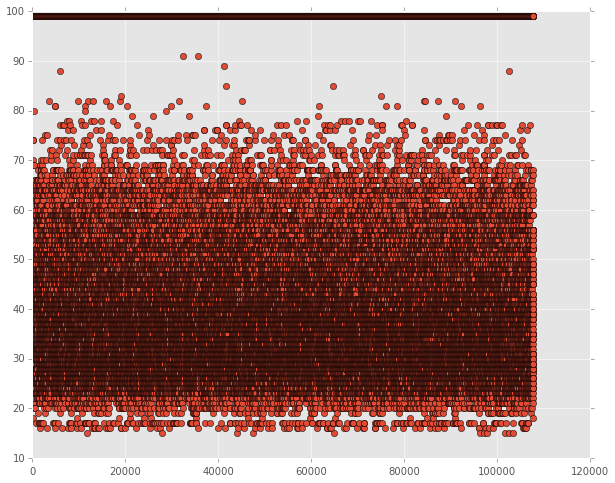

In [17]:
plt.plot(contract["AGE"].values, 'o')

In [16]:
def convert_gender(g):
    return {"Female": "F", "f": "F", "F": "F", "Male": "M", "m": "M", "M":"M", "Not Entered":"Unknown","Unknown":"Unknown"}[g]
    

contract["GENDER"] = contract["GENDER"].apply(convert_gender)
contract["VALUE_SEGMENT"][pd.isnull(contract["VALUE_SEGMENT"])] = "Unknown"
contract["HANDSET_NAME"][pd.isnull(contract["HANDSET_NAME"])] = "Other"
contract["AGE"][contract["AGE"] < 10] = 99
#contract["APPLE"] = contract["HANDSET_NAME"].apply(lambda x: x.lower().count("apple") > 0)
#contract = contract.drop(["HANDSET_NAME"], axis=1)

train = train.merge(contract)
test = test.merge(contract)

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [18]:
contract.to_csv("contract_clean.csv")

In [9]:
contract.describe()

,CONTRACT_KEY,AGE
count,1.077430e+05,107743.000000
mean,1.490276e+08,67.551330
std,4.113155e+06,31.126442
min,1.424050e+08,-29.000000
25%,1.454626e+08,36.000000
50%,1.492707e+08,61.000000
75%,1.524336e+08,99.000000
max,1.562334e+08,99.000000


In [8]:
def encode_onehot(df, cols):
    """
    One-hot encoding is applied to columns specified in a pandas DataFrame.
    
    Modified from: https://gist.github.com/kljensen/5452382
    
    Details:
    
    http://en.wikipedia.org/wiki/One-hot
    http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
    
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with one-hot encoding
    """
    vec = DictVectorizer()
    
    vec_data = pd.DataFrame(vec.fit_transform(df[cols].to_dict(outtype='records')).toarray())
    vec_data.columns = vec.get_feature_names()
    vec_data.index = df.index
    
    df = df.drop(cols, axis=1)
    df = pd.concat([df, vec_data], axis=1)
    return df

In [9]:
test["TARGET"] = -1
train_test = pd.concat([train, test])

In [10]:
train_testhot = encode_onehot(train_test, ["RATE_PLAN", "VALUE_SEGMENT", "GENDER"])
train_testhot["UNDEFINED_AGE"] = train_testhot["AGE"] == 99

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:18: FutureWarning: the 'outtype' keyword is deprecated, use 'orient' instead


In [11]:
train_hot = train_testhot[train_testhot["TARGET"] != -1]
test_hot = train_testhot[train_testhot["TARGET"] == -1]

In [27]:
np.corr([1, 1, 1], [1, 2, 3])

AttributeError: 'module' object has no attribute 'corr'

In [100]:
for c in train_hot.keys():
    print c + " -> " + str(pearsonr(train_hot[c], train_hot["TARGET"]))

206_SESSION_COUNT -> (0.08306300304066308, 1.4360655775294405e-115)
206_USAGE -> (0.13620369338649504, 4.504174097477524e-309)
207_SESSION_COUNT -> (0.10037909589691885, 4.0504106169966968e-168)
207_USAGE -> (0.15832316154367498, 0.0)
208_SESSION_COUNT -> (0.067832929753888146, 1.2586165092180627e-77)
208_USAGE -> (0.17170854702575516, 0.0)
209_SESSION_COUNT -> (0.10898408194202608, 5.4914797431873322e-198)
209_USAGE -> (0.20125842764140647, 0.0)
210_SESSION_COUNT -> (0.11830870401813123, 3.4586399717598126e-233)
210_USAGE -> (0.23346499048996844, 0.0)
AGE -> (-0.11875176503213314, 6.2034703707831809e-235)
APPLE -> (0.17649586789154689, 0.0)
CONTRACT_KEY -> (0.08127716323126602, 1.0132890007358164e-110)
TARGET -> (1.0, 0.0)
GENDER=F -> (0.03721250549325017, 1.5631664442130081e-24)
GENDER=M -> (0.082135429462874304, 4.8844797952534816e-113)
GENDER=Unknown -> (-0.099171795581591449, 3.9626535213674918e-164)
RATE_PLAN=2011 Bouquet 100 -> (0.0023020800218141318, 0.5272482801711631)
RATE_PL

In [101]:
q = train_hot.sample(1000)
m = MINE()
for c in train_hot.keys():
    m.compute_score(q[c], q["TARGET"])
    print c + " -> " + str(m.mic())

206_SESSION_COUNT -> 0.158161091146
206_USAGE -> 0.182291389943
207_SESSION_COUNT -> 0.159379784815
207_USAGE -> 0.194545110914
208_SESSION_COUNT -> 0.16713693363
208_USAGE -> 0.251163645143
209_SESSION_COUNT -> 0.154548518973
209_USAGE -> 0.237452310696
210_SESSION_COUNT -> 0.160456019249
210_USAGE -> 0.289046696608
AGE -> 0.0491549306423
APPLE -> 0.040426702365
CONTRACT_KEY -> 0.152862424297
TARGET -> 0.784919294525
GENDER=F -> 4.51867219442e-05
GENDER=M -> 0.00753349545578
GENDER=Unknown -> 0.00791209056729
RATE_PLAN=2011 Bouquet 100 -> 0.000384804231655
RATE_PLAN=2011 Bouquet 200 -> 0.000384804231655
RATE_PLAN=2011 Bouquet 25 -> 0.0
RATE_PLAN=2011 Bouquet 300 Max CTRL -> 0.0
RATE_PLAN=2011 Bouquet 50 -> 0.00209778505939
RATE_PLAN=2011 Bouquet Ctrl 100 -> 0.0
RATE_PLAN=2011 Bouquet Ctrl 200 -> 0.00209778505939
RATE_PLAN=2011 Bouquet Ctrl 25 -> 0.0
RATE_PLAN=2011 Bouquet Ctrl 50 -> 0.000481145151625
RATE_PLAN=2011 Business Bouquet 300 Max -> 0.0
RATE_PLAN=2011 Business Bouquet 500 ->

In [15]:
len(train_hot)

75422

## Using one-feature models to calc feature significance

In [55]:
samp = train_hot.sample(10000)
y = samp["TARGET"].values

In [59]:
for i in samp.keys(): print i

206_SESSION_COUNT
206_USAGE
207_SESSION_COUNT
207_USAGE
208_SESSION_COUNT
208_USAGE
209_SESSION_COUNT
209_USAGE
210_SESSION_COUNT
210_USAGE
AGE
APPLE
CONTRACT_KEY
TARGET
GENDER=F
GENDER=M
GENDER=Unknown
RATE_PLAN=2011 Bouquet 100
RATE_PLAN=2011 Bouquet 200
RATE_PLAN=2011 Bouquet 25
RATE_PLAN=2011 Bouquet 300 Max CTRL
RATE_PLAN=2011 Bouquet 50
RATE_PLAN=2011 Bouquet Ctrl 100
RATE_PLAN=2011 Bouquet Ctrl 200
RATE_PLAN=2011 Bouquet Ctrl 25
RATE_PLAN=2011 Bouquet Ctrl 50
RATE_PLAN=2011 Business Bouquet 300 Max
RATE_PLAN=2011 Business Bouquet 500
RATE_PLAN=2012 Bouquet 100
RATE_PLAN=2012 Bouquet 100 Ctrl Revamp
RATE_PLAN=2012 Bouquet 100 Revamp
RATE_PLAN=2012 Bouquet 200
RATE_PLAN=2012 Bouquet 200 Ctrl Revamp
RATE_PLAN=2012 Bouquet 200 Revamp
RATE_PLAN=2012 Bouquet 25
RATE_PLAN=2012 Bouquet 25 Ctrl Revamp
RATE_PLAN=2012 Bouquet 25 Revamp
RATE_PLAN=2012 Bouquet 300
RATE_PLAN=2012 Bouquet 300 MAX
RATE_PLAN=2012 Bouquet 35 Ctrl Flat
RATE_PLAN=2012 Bouquet 400
RATE_PLAN=2012 Bouquet 400 MAX
RATE

In [ ]:
cv = get_cross_validation_scores(SVC(kernel='rbf'), samp[["209_USAGE"]].values, y)
cross_validation_report(cv, labels)

In [48]:
X

array([[423, 9, 407, ..., 0.0, 0.0, 0.0],
       [360, 2222, 170, ..., 0.0, 0.0, 0.0],
       [274, 1714, 646, ..., 0.0, 0.0, 0.0],
       ..., 
       [1551, 281, 1479, ..., 0.0, 0.0, 0.0],
       [350, 968, 284, ..., 0.0, 0.0, 0.0],
       [2223, 11024, 2010, ..., 0.0, 0.0, 0.0]], dtype=object)

In [47]:
q = train_hot.sample(10000)
X = q[(q.keys().difference(['TARGET']))].values
y = q["TARGET"].values
labels = list(set(y))

In [44]:
cv = get_cross_validation_scores(RandomForestClassifier(n_estimators=10), X, y, labels=labels)
cross_validation_report(cv, labels)

                     precision         recall        f-score        support
              0        0.84847        0.91995        0.87935     1664.00000
              1        0.27607        0.17500        0.18222      336.00000
       total/av        0.56227       0.547475       0.530785         1000.0


In [483]:
q = train
X = q[(q.keys().difference(['TARGET']))].values
y = q["TARGET"].values
labels = list(set(y))

In [137]:
cv = get_cross_validation_scores(RandomForestClassifier(n_estimators=10), X, y, labels=labels)
cross_validation_report(cv, labels)

ValueError: could not convert string to float: Core

ValueError: X and y have incompatible shapes.
X has 32321 samples, but y has 75422.

In [19]:
q = test_hot
X = q[(q.keys().difference(['TARGET']))].values
#y = q["TARGET"].values
labels = list(set(y))

In [23]:
test_hot["TARGET"] = clf.predict(X)

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [27]:
res = test_hot[["CONTRACT_KEY", "TARGET"]]

In [28]:
res.columns = ["CONTRACT_KEY", "PREDICTED_TARGET"]

In [33]:
res.groupby(by="PREDICTED_TARGET").count()

,CONTRACT_KEY
PREDICTED_TARGET,
0,32316
1,5


In [494]:
res.to_csv("submission.csv", index=False)

In [231]:
train["210_USAGE"][train["210_USAGE"] == 0]
train["p2"] = (train["209_USAGE"] * 1.0) / train["210_USAGE"]

In [388]:
len(set(test["CONTRACT_KEY"]))

32321

In [386]:
len(set(test["CONTRACT_KEY"]) - set(train["CONTRACT_KEY"]))

32321

In [248]:
len(test_hot)

64642

In [117]:
r = pd.read_csv("roaming_monthly.csv")

In [118]:
r.sample(100)

,CONTRACT_KEY,CALL_MONTH_KEY,USAGE,SESSION_COUNT
1053,146713849,207,13,11
258,143315518,210,264,516
3899,156179939,207,2,3
2464,151766335,210,121,238
1956,150000443,207,125,25
478,143965623,209,728,1140
1729,149438674,206,3,27
3429,154308067,208,329,215
730,145137561,206,2,1
3487,154475260,207,4,11
